In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report
import pandas as pd
import time

In [240]:
# Thiết lập cách hiển thị
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)    

In [241]:
df = pd.read_csv('D:\\Project_Portfolio\\Customer-Churn-on-AWS\\data\dataset\\WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Gray\AppData\Local\Temp\ipykernel_49048\1590493771.py:1: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('D:\\Project_Portfolio\\Customer-Churn-on-AWS\\data\dataset\\WA_Fn-UseC_-Telco-Customer-Churn.csv')


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Ý nghĩa các nhóm biến

***Nhóm 1 Thông tin khách hàng***

- `customerID:` mã định danh, không mang thông tin dự đoán, cần loại bỏ.

- `gender`, `SeniorCitizen`, `Partner`, `Dependents`: đặc điểm nhân khẩu học.

***Nhóm 2: Thông tin dịch vụ***

- `PhoneService`, `MultipleLines`

- `InternetService`, `OnlineSecurity`, `OnlineBackup`

- `DeviceProtection`, `TechSupport`

- `StreamingTV`, `StreamingMovies`

-> phản ánh mức độ sử dụng dịch vụ của khách hàng.

***Nhóm 3: Thông tin hợp đồng và thanh toán***

- `Contract`, `PaperlessBilling`, `PaymentMethod`

- `tenure`: thời gian gắn bó với công ty

- `MonthlyCharges`, `TotalCharges`: chi phí dịch vụ

**BIẾN MỤC TIÊU:**

`Churn:` thể hiện khách hàng rời bỏ (Yes) hoặc tiếp tục sử dụng (No) dịch vụ.

In [242]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Nhận xét tổng quan dữ liệu

Tập dữ liệu gồm 7.043 bản ghi, tương ứng với 7.043 khách hàng.

Dữ liệu có 21 cột, trong đó:

- 18 biến dạng categorical (object)

- 2 biến số nguyên (int64): `SeniorCitizen`, `tenure`

- 1 biến số thực (float64): `MonthlyCharges`

### Tình trạng dữ liệu

Không có giá trị thiếu (Non-Null = 7043 cho tất cả các cột) → dữ liệu khá sạch.
Lưu ý: Cột `TotalCharges` đang ở dạng object, dù về bản chất là giá trị số.


In [243]:
### THỐNG KÊ CƠ BẢN VỀ NUMBERIC
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


**Nhận xét thống kê các biến số**

**Biến SeniorCitizen**

`SeniorCitizen` là biến nhị phân (0/1), thể hiện khách hàng có phải người cao tuổi hay không.

Giá trị `mean = 0.162` cho thấy:

- Khoảng **16.2%** khách hàng là người cao tuổi

- Phần lớn khách hàng không thuộc nhóm `SeniorCitizen`.

- `std = 0.369` phản ánh sự phân bố lệch về phía giá trị 0.

-> Điều này cho thấy nhóm khách hàng cao tuổi chiếm tỷ lệ nhỏ trong tập dữ liệu.

**Biến tenure**

`tenure` biểu thị số tháng khách hàng gắn bó với công ty.

Giá trị:

- Min = 0, Max = 72 → khách hàng mới đến khách hàng gắn bó lâu năm.

- Mean ≈ 32.37 tháng, Median = 29 tháng → phân bố hơi lệch phải.

Các phân vị:

- 25% khách hàng có tenure ≤ 9 tháng

- 50% khách hàng có tenure ≤ 29 tháng

- 75% khách hàng có tenure ≤ 55 tháng

**Biến MonthlyCharges**

`MonthlyCharges` thể hiện chi phí dịch vụ hàng tháng của khách hàng.

Giá trị:

- Min = 18.25 USD, Max = 118.75 USD

- Mean ≈ 64.76 USD, Median = 70.35 USD

- Median lớn hơn mean cho thấy:

-> Phân bố hơi lệch trái, tồn tại một nhóm khách hàng trả phí thấp.

- 75% khách hàng có chi phí hàng tháng ≤ 89.85 USD.


In [244]:
### THỐNG KÊ CƠ BẢN VỀ CATEGORY/OBJECT

df.describe(include='O')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,6531,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,20.2,No
freq,1,3555,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,11,5174


**Nhận xét thống kê các biến category/object**

**1. Các biến dịch vụ viễn thông**

`MultipleLines`

Có 3 giá trị phân loại chính.

Giá trị phổ biến nhất là “No” với 3641 khách hàng.

Điều này cho thấy phần lớn khách hàng chỉ sử dụng một đường dây, không đăng ký dịch vụ nhiều đường.

-> Khách hàng sử dụng ít dịch vụ thường có chi phí thấp hơn nhưng cũng dễ rời bỏ nếu không có ràng buộc.

`InternetService`

Có 3 loại dịch vụ Internet.

`Fiber optic` là loại được sử dụng nhiều nhất (3096 khách hàng).

`Fiber optic` thường đi kèm với:

- Chi phí cao

- Tốc độ nhanh
→ Đây là nhóm có khả năng churn cao, cần phân tích kỹ trong các bước tiếp theo.

`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`

Phần lớn khách hàng không đăng ký các dịch vụ bổ sung này.

OnlineBackup: 4933 khách hàng chọn “No”

DeviceProtection: 6361 khách hàng không sử dụng

Riêng TechSupport có 3 nhóm giá trị, cho thấy sự đa dạng trong lựa chọn dịch vụ.

-> Việc không sử dụng các dịch vụ gia tăng thường liên quan đến churn cao hơn do mức độ gắn kết thấp.


`StreamingTV`, `StreamingMovies`

- Có 3 nhóm giá trị cho mỗi biến.

- Phân bố khá cân bằng giữa các nhóm.

- Các dịch vụ giải trí thường làm tăng MonthlyCharges, từ đó có thể ảnh hưởng gián tiếp đến churn


**Biến hợp đồng & thanh toán**

**Contract**

Có 3 loại hợp đồng.

`Month-to-month` là loại phổ biến nhất với 3875 khách hàng.

Hợp đồng ngắn hạn thường:

- Ít ràng buộc

- Dễ hủy dịch vụ
→ Đây là nhóm có tỷ lệ churn cao nhất.


`PaperlessBilling`

Có 2 giá trị, trong đó:

“Yes” chiếm ưu thế với 4171 khách hàng

Hóa đơn điện tử thường đi kèm:

- Thanh toán linh hoạt

- Hợp đồng ngắn hạn

`PaymentMethod`

Có 4 hình thức thanh toán.

Electronic check là phương thức phổ biến nhất (2365 khách hàng).

Phương thức này thường liên quan đến:

- Thanh toán thủ công

- Ít cam kết dài hạn
→ Có xu hướng churn cao hơn so với thanh toán tự động.

**3. Biến chi phí & mục tiêu**

`TotalCharges`

Có tới 6531 giá trị khác nhau, cho thấy:

Đây là biến liên tục, dù đang được lưu dưới dạng object

Mỗi khách hàng gần như có một giá trị TotalCharges riêng

Cần chuyển sang numeric trước khi đưa vào mô hình.

`Churn`

Có 2 giá trị phân loại: Yes / No.

Giá trị phổ biến nhất là “No” với 5174 khách hàng.

Điều này cho thấy:

Dữ liệu mất cân bằng nhẹ

Khoảng 26–27% khách hàng đã churn


C:\Users\Gray\AppData\Local\Temp\ipykernel_49048\2547290894.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Churn', palette='pastel')


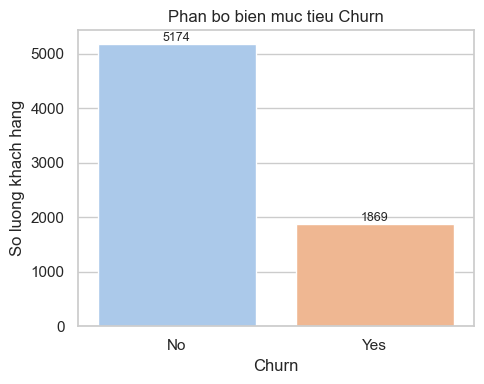

In [245]:
# Phân bố biến mục tiêu Churn

plt.figure(figsize=(5,4))
ax = sns.countplot(data=df, x='Churn', palette='pastel')
plt.title('Phan bo bien muc tieu Churn')
plt.xlabel('Churn')
plt.ylabel('So luong khach hang')
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, rotation=0)
plt.tight_layout()
plt.show()

Biểu đồ cột cho thấy số khách hàng không rời bỏ (No) nhiều hơn khá rõ so với rời bỏ (Yes). Tập dữ liệu hơi mất cân bằng nhưng vẫn dùng được cho mô hình.

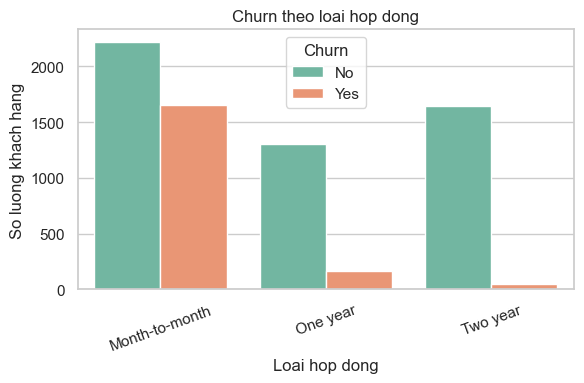

In [246]:

# Churn theo loại hợp đồng (Contract)
plt.figure(figsize=(6,4))
ax2 = sns.countplot(data=df, x='Contract', hue='Churn', palette='Set2')
plt.title('Churn theo loai hop dong')
plt.xlabel('Loai hop dong')
plt.ylabel('So luong khach hang')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

- Hợp đồng `Month-to-month `có tỉ lệ Churn cao hơn rõ rệt.

- Hợp đồng `One year` và `Two year` có ít Churn hơn nhiều.

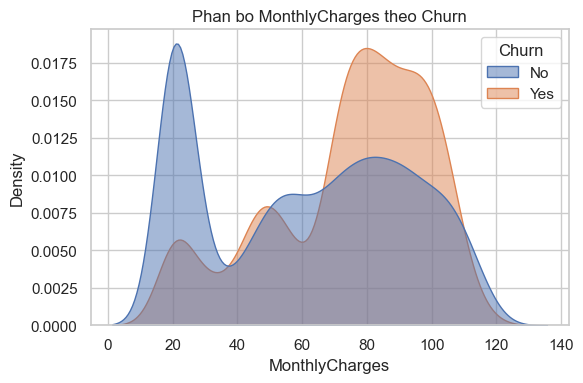

In [247]:
# Phân bố MonthlyCharges theo Churn
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, alpha=0.5)
plt.title('Phan bo MonthlyCharges theo Churn')
plt.tight_layout()
plt.show()

Biểu đồ mật độ (KDE):

- Khách hàng Churn = Yes tập trung nhiều hơn ở mức MonthlyCharges cao.
- Khách hàng Churn = No thiên về mức cước thấp hơn.

-> Chi phí hàng tháng càng cao thì khả năng rời bỏ có xu hướng tăng.

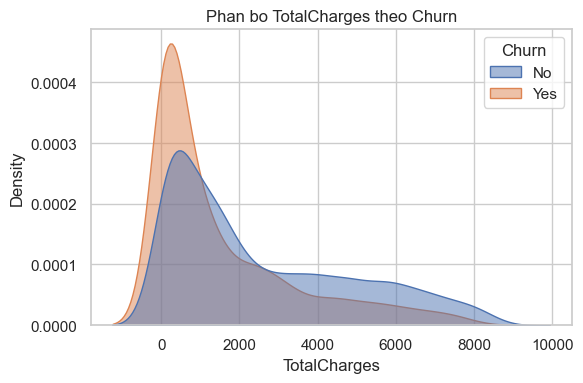

In [248]:
# Phân bố TotalCharges theo Churn
plt.figure(figsize=(6,4))
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
sns.kdeplot(data=df.dropna(subset=['TotalCharges']), x='TotalCharges', hue='Churn', fill=True, common_norm=False, alpha=0.5)
plt.title('Phan bo TotalCharges theo Churn')
plt.tight_layout()
plt.show()

- TotalCharges (tổng tiền đã trả) của nhóm Churn = No trải đều hơn, nhiều người trả tổng khá cao (gắn bó dài).
- Nhóm Churn = Yes thường có TotalCharges thấp hơn (rời sớm).

Điều này phù hợp với trực giác: khách rời sớm thì tổng tiền tích lũy không lớn.

                SeniorCitizen    tenure  MonthlyCharges  TotalCharges
SeniorCitizen        1.000000  0.016567        0.220173      0.102411
tenure               0.016567  1.000000        0.247900      0.825880
MonthlyCharges       0.220173  0.247900        1.000000      0.651065
TotalCharges         0.102411  0.825880        0.651065      1.000000


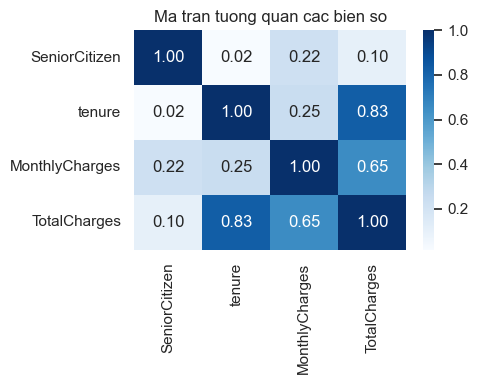

In [249]:
# Ma trận tương quan các biến số
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[numeric_cols].corr()
print(corr)

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Ma tran tuong quan cac bien so')
plt.tight_layout()
plt.show()

- `tenure` tương quan rất cao với TotalCharges (khách dùng lâu thì tổng tiền trả cao).
- `MonthlyCharges` tương quan vừa phải với TotalCharges.
- `SeniorCitizen` chỉ tương quan rất yếu với các biến số khác.

C:\Users\Gray\AppData\Local\Temp\ipykernel_49048\363185554.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Pastel1', ax=axes[0])
C:\Users\Gray\AppData\Local\Temp\ipykernel_49048\363185554.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df.dropna(subset=['TotalCharges']), x='Churn', y='TotalCharges', palette='Pastel2', ax=axes[1])
C:\Users\Gray\AppData\Local\Temp\ipykernel_49048\363185554.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='tenure', palette='S

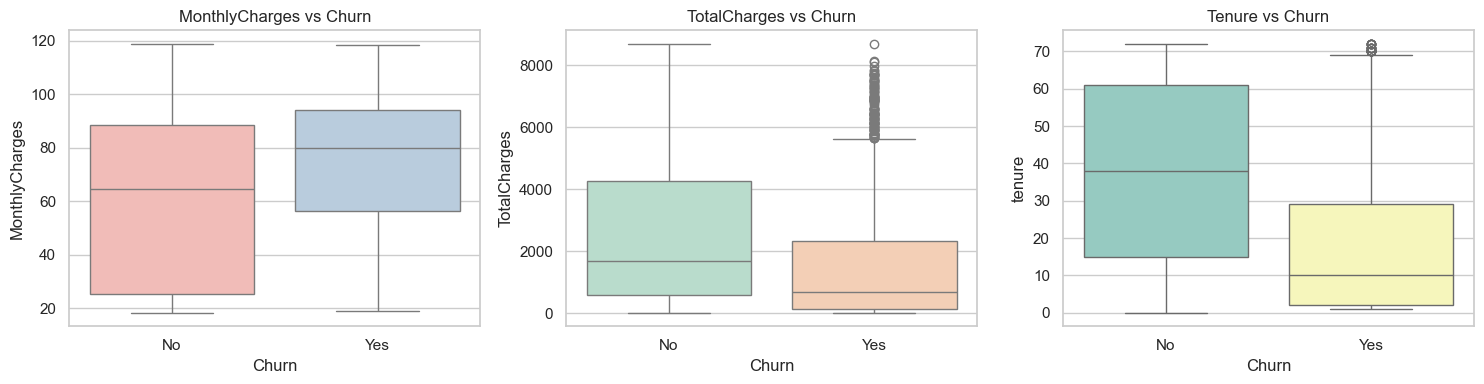

In [250]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=False)

sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette='Pastel1', ax=axes[0])
axes[0].set_title('MonthlyCharges vs Churn')

sns.boxplot(data=df.dropna(subset=['TotalCharges']), x='Churn', y='TotalCharges', palette='Pastel2', ax=axes[1])
axes[1].set_title('TotalCharges vs Churn')

sns.boxplot(data=df, x='Churn', y='tenure', palette='Set3', ax=axes[2])
axes[2].set_title('Tenure vs Churn')

plt.tight_layout()
plt.show()

**Nhận xét mối quan hệ giữa các biến số và Churn**

**MonthlyCharges vs Churn**

Nhóm Churn = Yes có MonthlyCharges trung vị cao hơn rõ rệt so với nhóm Churn = No.

Phân bố của nhóm churn:

- Tập trung nhiều ở mức phí cao

- Ít khách hàng churn ở mức phí rất thấp

- Nhóm Churn = No có phân bố rộng hơn, bao gồm nhiều khách hàng trả phí thấp.

-> Khách hàng có chi phí hàng tháng cao có xu hướng rời bỏ dịch vụ nhiều hơn, cho thấy giá cả là một yếu tố quan trọng ảnh hưởng đến churn.

**TotalCharges vs Churn**

Nhóm Churn = No có `TotalCharges` trung vị cao hơn đáng kể.

Nhóm Churn = Yes:

`TotalCharges` chủ yếu ở mức thấp

Tuy có một số ngoại lệ (outliers) cao, nhưng số lượng không nhiều.

Điều này phản ánh rằng:

- Phần lớn khách hàng churn là khách hàng mới, chưa đóng góp nhiều tổng chi phí.

-> Khách hàng có `TotalCharges` thấp có khả năng churn cao hơn, do họ chưa gắn bó lâu dài với dịch vụ.

**Tenure vs Churn**

Biểu đồ cho thấy sự khác biệt rất rõ ràng giữa hai nhóm:

- Churn = Yes có tenure rất thấp, trung vị khoảng vài tháng.

- Churn = No có tenure cao hơn nhiều, phân bố trải dài đến mức tối đa.

- Chỉ có rất ít khách hàng churn ở mức tenure cao (outliers).

-> Tenure là biến ảnh hưởng mạnh nhất đến churn – khách hàng rời bỏ dịch vụ chủ yếu trong giai đoạn đầu sử dụng.

### TIỀN XỬ LÝ

In [251]:
# Chuyển totalCharges sang dạng số
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df_clean = df.dropna(subset=['TotalCharges']).copy()
df_clean = df_clean.drop(columns=['customerID'])

In [252]:
# Ma hoa bien muc tieu Churn thanh 0/1
df_clean['Churn'] = df_clean['Churn'].map({'No': 0, 'Yes': 1})

In [253]:
# Tach cot so va cot phan loai
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = [c for c in df_clean.columns if c not in numeric_cols + ['Churn']]

In [254]:
# One-hot encode cho cac cot phan loai
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

In [255]:

# X va y
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

THRESHOLD = 0.3  